In [3]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
plt.rc('font', size=18)
import cartopy.crs as ccrs
import xarray as xr
import salem
import numpy as np
import cv2
import seaborn as sns
from pycaret.regression import *
!export PYTHONPATH=$PYTHONPATH:'~/GIT_REPOS/spacebridge/pkgs'
import datetime
import dask.dataframe as dd
import tensorflow as tf

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
# Useful summary statistics function for numpy arrays
def summary(arr):
    nmax = np.nanmax(arr) if len(arr) > 0 else None
    nmin = np.nanmin(arr) if len(arr) > 0 else None
    return nmax, nmin, (nmax+nmin)/2 if len(arr) > 0 else None

## GNSS-R

### Exploration of GNSS-R locations

In [3]:
def timegrid_description(pth):
    """
    A function that given a path to a GNSS-R netcdf returns 
        - the datetime based on the filename. Note format of the datetime matters.
        - the minimum lon/lat pair, and
        - the maximum lon/lat pair
    pth (str): pth to GNSS nc file
    """
    
    Datetime = pd.to_datetime(pth[70:89], format='%Y-%m-%dT%H-%M-%S')
    nc = xr.open_dataset(pth)
    minlon, maxlon, _ = summary(nc.longitude.values)
    minlat, maxlat, _ = summary(nc.latitude.values)
    return Datetime, minlon, minlat, maxlon, maxlat

timegrid_description('/volstore/spacebridge/gnssr_grzice/data/spire_gnss-r_L2_grzIce_v07.00_2020-03-01T00-07-19_FM102_G29.nc')

(Timestamp('2020-03-01 00:07:19'),
 -19.33371446234287,
 -61.21857892306003,
 -35.337494628984075,
 -74.51288840744537)

In [176]:
GLOB = '/volstore/spacebridge/gnssr_grzice/data/spire_gnss-r_L2_grzIce_v07.00_2020-03*'
files = glob.glob(GLOB) #[os.path.join(DIR,pth) for pth in os.(DIR)]
files.sort()
data = []
filenum = 1
for f in files:
    if filenum%100 == 1:
        print(filenum) 
    data.append(timegrid_description(f))
    filenum += 1
data

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
2901
3001
3101
3201
3301
3401
3501
3601
3701


[(Timestamp('2020-03-01 00:07:19'),
  -19.33371446234287,
  -61.21857892306003,
  -35.337494628984075,
  -74.51288840744537),
 (Timestamp('2020-03-01 01:21:44'),
  112.73288178863733,
  -53.97270035591964,
  104.58514616138432,
  -65.03620621218894),
 (Timestamp('2020-03-01 01:22:34'),
  -22.75412913385634,
  -73.01462328206343,
  -66.97531975621325,
  -76.3402859988352),
 (Timestamp('2020-03-01 01:30:14'),
  -99.30529844740113,
  -66.91267149150687,
  -109.434616435003,
  -71.51582759268096),
 (Timestamp('2020-03-01 01:31:42'),
  -156.84856348803868,
  -79.21315141682787,
  -156.9241720764131,
  -79.35928473771908),
 (Timestamp('2020-03-01 01:33:08'),
  -32.40404419960339,
  -80.38872536085665,
  -58.86224592984405,
  -82.21287858521173),
 (Timestamp('2020-03-01 01:37:14'),
  -13.738220846675063,
  -65.24326428915072,
  -31.31768045707463,
  -72.22528140786285),
 (Timestamp('2020-03-01 01:39:48'),
  -137.18949924362101,
  -48.62575731088403,
  -146.3926421155117,
  -64.00592025081467)

In [184]:
data = pd.DataFrame(data, columns=['DateTimeStamp', 'minlon', 'minlat', 'maxlon', 'maxlat'])
data.to_csv('~/domaininfo_202003.csv', sep=',', header=False, index=False)

In [192]:
data = pd.read_csv('/volstore/spacebridge/gnssr_grzice/data/domaininfo_202003.csv', 
                   header=None, 
                   names=['DateTimeStamp', 'minlon', 'minlat', 'maxlon', 'maxlat'])
data

DateTimeStamp      minlon     minlat      maxlon     maxlat
0     2020-03-01 00:07:19  -19.333714 -61.218579  -35.337495 -74.512888
1     2020-03-01 01:21:44  112.732882 -53.972700  104.585146 -65.036206
2     2020-03-01 01:22:34  -22.754129 -73.014623  -66.975320 -76.340286
3     2020-03-01 01:30:14  -99.305298 -66.912671 -109.434616 -71.515828
4     2020-03-01 01:31:42 -156.848563 -79.213151 -156.924172 -79.359285
...                   ...         ...        ...         ...        ...
3795  2020-03-30 23:07:03  -54.509252 -76.986349  -74.215729 -79.555136
3796  2020-03-30 23:10:08   19.445415 -68.484963   18.243320 -69.231584
3797  2020-03-30 23:13:47   24.386863 -66.431634   17.135900 -69.691613
3798  2020-03-30 23:29:26   30.450902 -47.706696   23.604617 -62.445352
3799  2020-03-30 23:47:09  -51.429154 -76.934531  -72.324567 -78.744336

[3800 rows x 5 columns]

Text(0.5, 1.0, 'maximum coordinates')

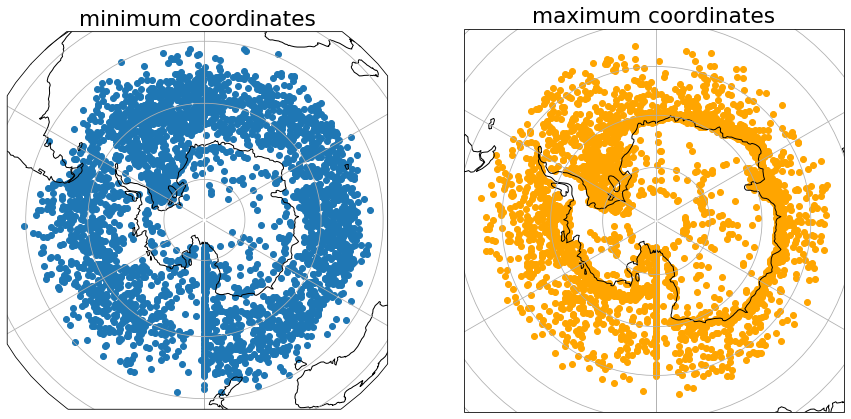

In [208]:
fig, axes = plt.subplots(
    1, 2, subplot_kw=dict(projection=ccrs.Orthographic(0,-90))
)
axes[0].scatter(x=data['minlon'], y=data['minlat'], transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].gridlines()
axes[0].set_title('minimum coordinates')
axes[1].scatter(x=data['maxlon'], y=data['maxlat'], transform=ccrs.PlateCarree(), c='orange')
axes[1].coastlines()
axes[1].gridlines()
axes[1].set_title('maximum coordinates')

### Create table with feature vars and labels for modeling

In [218]:
gnss1 = xr.open_dataset('/volstore/spacebridge/gnssr_grzice/data/spire_gnss-r_L2_grzIce_v07.00_2020-03-02T09-52-52_FM099_G26.nc') #/volstore/spacebridge/gnssr_grzice/data/spire_gnss-r_L2_grzIce_v07.00_2020-03-01T00-07-19_FM102_G29.nc
gnss1

<xarray.Dataset>
Dimensions:                 (time_50Hz: 1897, time: 38, bands: 2, ecef: 3)
Coordinates:
  * time_50Hz               (time_50Hz) timedelta64[ns] 14666 days 09:53:10.0...
  * time                    (time) timedelta64[ns] 14666 days 09:53:10.532497...
  * bands                   (bands) int32 1 2
  * ecef                    (ecef) |S1 b'x' b'y' b'z'
Data variables: (12/28)
    sea_ice_presence        (time) int32 ...
    sea_ice_type            (time) int32 ...
    reflectivity            (bands, time) float64 ...
    snr_reflected           (bands, time) float64 ...
    snr_direct              (bands, time) float64 ...
    snr_l1b_reflected       (bands, time_50Hz) float64 ...
    ...                      ...
    flag_land               (time) int32 ...
    flag_high_elevation     (time) int32 ...
    flag_low_elevation      (time) int32 ...
    flag_antenna_gain       (bands, time) int32 ...
    flag_climatology        (time) int32 ...
    flag_master             (time) int32 ...
Attributes: (12/26)
    processing_center:           Spire Processing Center
    proc_version:                v07.00
    mission:                     Spire
    creation_time:               2022-01-19 16:36:59 UTC
    wavelength_l1:               0.19029367
    wavelength_l2:               0.24421021
    ...                          ...
    fill_value:                  -999
    leo_sat:                     099
    occultation_sat:             G26
    gps_seconds_start:           1267177990.5324972
    gps_seconds_stop:            1267178027.5315511
    history:                     derived from:\nspire_gnss-r_L1B_grzRfl_v07.0...

**Variable decisions**

- Only using variables that have time dimension, i.e. noise_rx and noise_l1b variables are ignored
- variables with additional dimensions, i.e. bands and ecef are split into multiple variables
- only timesteps where flag_master == 0 are kept
- ~~All variables are normalized according to the valid range provided~~ No normalization is done as per the TabNet guidelines. 



In [37]:
def norm(ser, valid_range):
    """
    Normalize given series, ser, based on the valid range
    """
    min = valid_range[0]
    max = valid_range[1]
    return (ser - min)/(max - min)

In [171]:
def get_series(xr_gnss, varname, use_master_flag=True, normalize=True):
    """
    xr_gnss: an xarray dataset or dataArray 
    varname: name of the variable to be extracted
    use_master_flag: Boolean indicating whether to 
                    include only the timesteps where
                    flag_master == 0
                    
    Returns: a numpy array of values of given variable
            name split into multiple columns if variable
            has bands or ecef dimensions.
    """
    split_by_bands = ['reflectivity',
            'snr_reflected',
            'snr_direct',
            'phase_noise',
            'excess_phase_noise',
            'power_reflected',
            'power_direct',
            'antenna_gain_reflected',
            'antenna_gain_direct',
            ]
    split_by_ecef = ['rx_pos',
            'tx_pos',
            'spec_pos',]
    
    if varname in split_by_ecef:
        ser = xr_gnss[varname].T[:, xr_gnss.flag_master == 0].values if use_master_flag else xr_gnss[var].T.values
    elif varname in split_by_bands:
        ser = xr_gnss[varname][:, xr_gnss.flag_master == 0].values if use_master_flag else xr_gnss[var].values
    else: 
        ser = xr_gnss[varname][xr_gnss.flag_master == 0].values if use_master_flag else xr_gnss[var].values
    ser = norm(ser, valid_range=xr_gnss[varname].valid_range) if normalize else ser

    return ser

In [192]:
def extract_variables(xr_gnss, use_master_flag=True, normalize=True):
    """
    xr_gnss: an xarray dataset or dataarray
    use_master_flag: Boolean indicating whether to 
                    include only the timesteps where
                    flag_master == 0
    
    Returns: a numpy array containing the rectangular 
            data with variables as columns and timesteps as 
            rows, and a vector of column names.
    """
    keys = ['reflectivity',
            'snr_reflected',
            'snr_direct',
            'phase_noise',
            'excess_phase_noise',
            'power_reflected',
            'power_direct',
            'antenna_gain_reflected',
            'antenna_gain_direct',
            'rx_pos',
            'tx_pos',
            'spec_pos',
            'angle_of_elevation',
            'longitude',
            'latitude']
    
    data = []
    columns = []
    bands = xr_gnss.bands.values
    ecef = ['x','y','z']
    if any(xr_gnss.flag_master == 0):
        dt = pd.to_datetime(f'{xr_gnss.year}-{xr_gnss.month:02d}-{xr_gnss.day:02d} {xr_gnss.hour:02d}:{xr_gnss.minute:02d}:{xr_gnss.second}')
        datetimes = pd.to_datetime(np.append(np.array([np.datetime64(dt)]), np.datetime64(dt) + np.cumsum(np.diff(xr_gnss.time[xr_gnss.flag_master == 0].values))))
        dates = datetimes.strftime("%Y%m%d")
        times = datetimes.strftime("%H%M%S.%f")
        data.append(dates)
        columns.append('date')
        data.append(times)
        columns.append('time')
        for var in keys:
            vardata = get_series(xr_gnss, var, use_master_flag=use_master_flag, normalize=normalize)
            
            if len(vardata.shape) == 2:
                numser = vardata.shape[0]
                [data.append(ser) for ser in vardata]
                suffix = [bands[num] if numser == 2 else ecef[num] if numser == 3 else None for num in range(numser)]
                [columns.append(var + str(suf)) for suf in suffix]
            else:
                data.append(vardata)
                columns.append(var)

    
    return np.array(data).T, columns
    

In [196]:
data, columns = extract_variables(gnss1, normalize=False)
if len(data) > 0:
    df = pd.DataFrame(data=data, columns=columns)
df.head()

date           time reflectivity1 reflectivity2 snr_reflected1  \
0  20200302  095310.032509      0.049312      0.044003      55.042502   
1  20200302  095311.032483      0.029934      0.028114      32.645362   
2  20200302  095312.032457      0.042125      0.033393      44.965363   
3  20200302  095313.032431      0.071815      0.055946      78.354536   
4  20200302  095314.032406       0.03385      0.031587      36.628942   

  snr_reflected2  snr_direct1 snr_direct2 phase_noise1 phase_noise2  \
0      34.784221   1033.31267  719.370207     0.398935     0.445769   
1      22.408029  1009.620079  725.356325     0.820932     0.736247   
2      26.366012   987.363866  717.000355     0.638372     0.535783   
3      44.859579   1008.48546  726.702644     0.342523     0.316064   
4      25.254272  1000.217685  724.624598     1.112314     0.916678   

  excess_phase_noise1 excess_phase_noise2 power_reflected1 power_reflected2  \
0            0.264147            0.276214    362887.529412    702860.062044   
1            0.645912            0.524996        217861.12    459771.604129   
2            0.489243            0.341033        297635.84    537512.803381   
3            0.229551             0.16676        513838.08     900756.42781   
4            0.947084            0.717688        243655.68    515676.430698   

    power_direct1    power_direct2 antenna_gain_reflected1  \
0  6697402.086348  14149237.857043                6.382463   
1  6543987.350342   14266814.92456                6.382463   
2  6399873.470571  14102690.135512                6.263727   
3  6536640.438362  14293258.811596                6.159462   
4  6483104.779645  14252442.623713                6.159462   

  antenna_gain_reflected2 antenna_gain_direct1 antenna_gain_direct2  \
0                4.707911             5.895467             4.274888   
1                4.707911             5.895467             4.274888   
2                4.614785             5.780884              4.18116   
3                4.533009             5.680265             4.098855   
4                4.533009             5.680265             4.098855   

          rx_posx         rx_posy         rx_posz          tx_posx  \
0   3415951.43852 -1023580.468892 -5882376.164817 -22790796.684848   
1  3409301.434915 -1023839.011439 -5886199.683847 -22789251.667238   
2  3402647.254643  -1024095.34044 -5890016.001336 -22787706.366684   
3  3395988.904573 -1024349.454023 -5893825.112871 -22786160.782826   
4  3389326.390127 -1024601.352313 -5897627.015215 -22784614.915309   

          tx_posy          tx_posz       spec_posx       spec_posy  \
0  -5439385.91514 -12744002.732288  1323689.280877 -1294688.401714   
1  -5439894.62381 -12746532.323226  1320079.100012 -1294109.882003   
2 -5440403.472379 -12749061.645798   1316465.14969 -1293531.073471   
3 -5440912.461018 -12751590.700521  1312847.424938 -1292951.973113   
4 -5441421.589896  -12754119.48791  1309225.919124 -1292372.579483   

        spec_posz angle_of_elevation  longitude   latitude  
0 -6082998.925755           5.034332 -44.366013 -73.177607  
1 -6083900.406569           5.073794 -44.431436 -73.205541  
2 -6084800.442629           5.113293 -44.497146 -73.233474  
3 -6085699.029526           5.152829 -44.563144 -73.261408  
4 -6086596.162854           5.192402 -44.629433 -73.289341

### Labels

In [248]:
def latlon_to_xyidx(lon, lat, dslon, dslat):
    # First, find the index of the grid point nearest a specific lat/lon.   
    abslat = (dslat-lat)**2
    abslon = (dslon-lon)**2
    c = np.sqrt(abslon + abslat)

    ([xloc], [yloc]) = np.where(c == np.min(c))
    return xloc, yloc

In [220]:
def create_label_columns(df, dsit):
    """
    df: Pandas dataFrame with all feature variables
    dsit: icetype netcdf dataset
    """
    lons = df.longitude.values
    lats = df.latitude.values
    for (lon, lat) in zip(lons, lats):
        print(lon, lat)
        xy = latlon_to_xyidx(lon, lat,dsit.LON.values, dsit.LAT.values)
    df['YI_conc'] = np.array([dsit.YI.sel(X=x,Y=y).values for (x,y) in xy])
    df['FYI_conc'] = np.array([dsit.FYI.sel(X=x,Y=y).values for (x,y) in xy])
    df['MYI_conc'] = np.array([dsit.MYI.sel(X=x,Y=y).values for (x,y) in xy])
    
    return df

<AxesSubplot:>

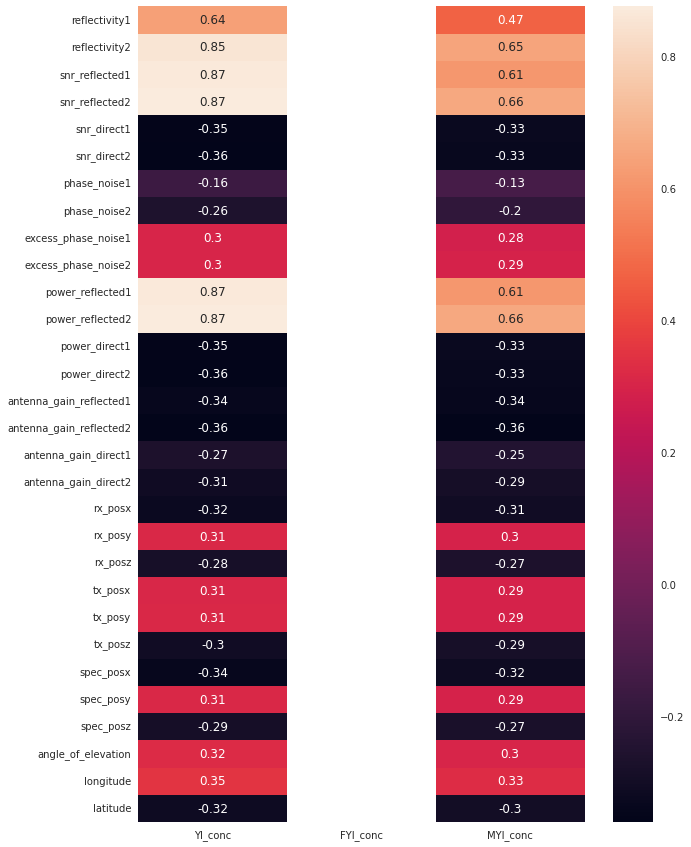

In [387]:
# Feature Engineering and Selection

# Correlation with target variables
corrdf = pd.DataFrame([df.drop(columns=['YI_conc', 'FYI_conc', 'MYI_conc']).corrwith(df[col]) for col in ['YI_conc', 'FYI_conc', 'MYI_conc']]).T
# Note that FYI_conc is 0 everywhere here
corrdf.columns = ['YI_conc', 'FYI_conc', 'MYI_conc']
plt.subplots(1,1,figsize=(10,15))
sns.heatmap(corrdf, annot=True)

<AxesSubplot:>

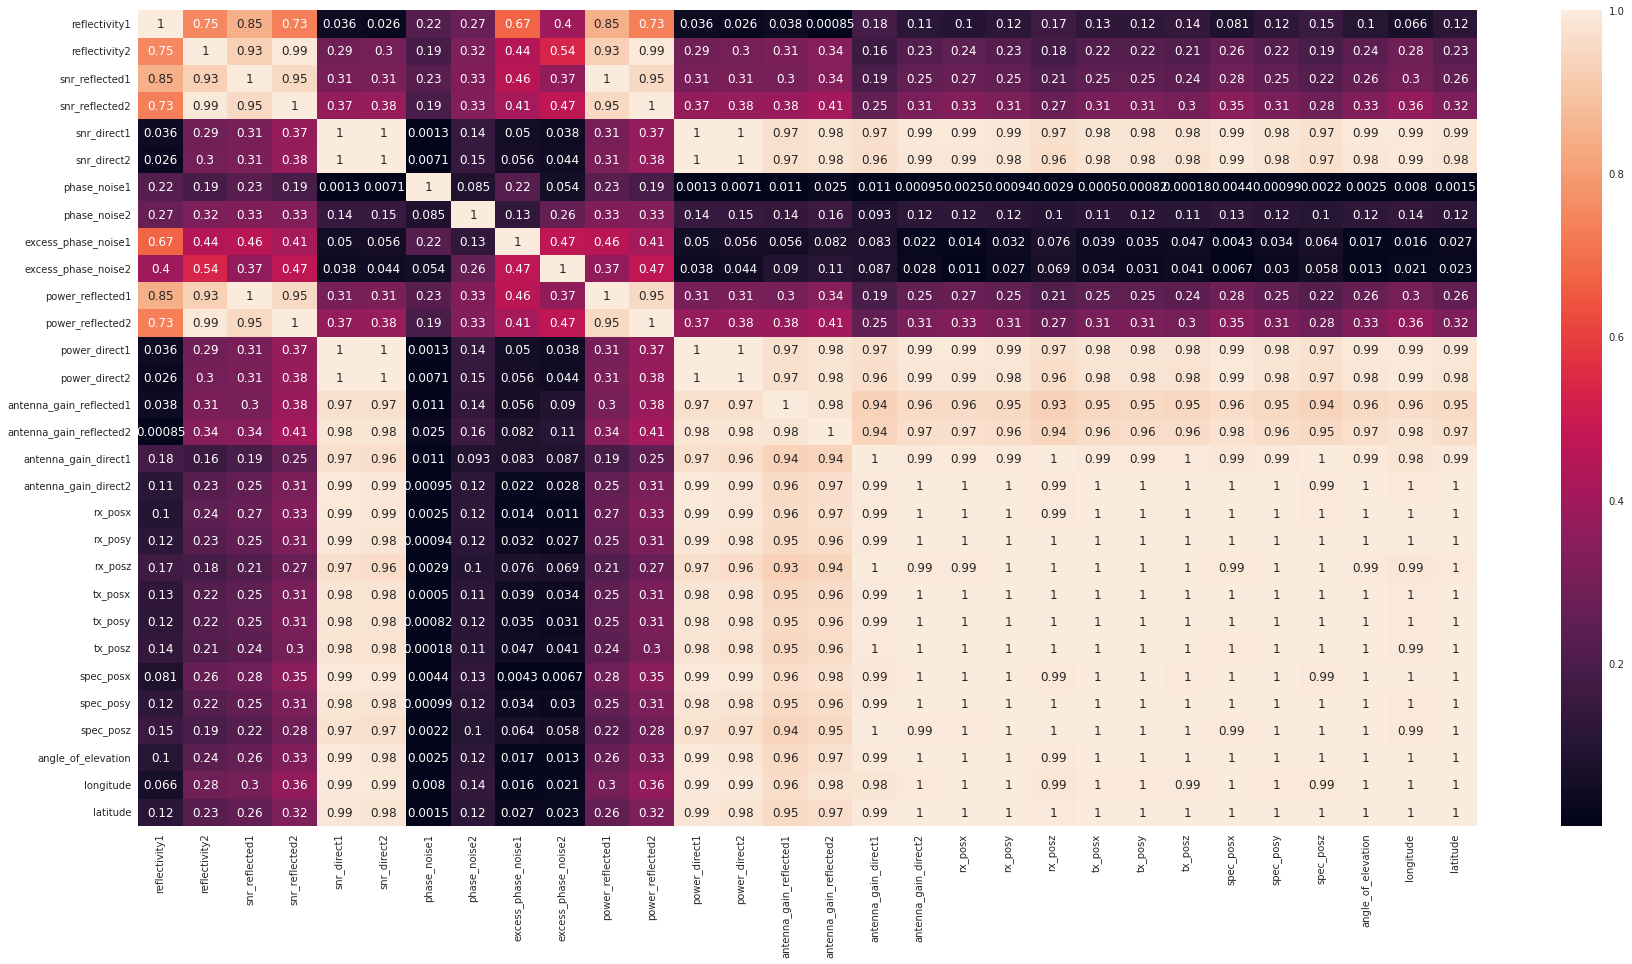

In [425]:
features = df.drop(columns=['YI_conc', 'FYI_conc', 'MYI_conc'])
plt.subplots(1,1,figsize=(30,15))
sns.heatmap(features.corr().abs(), annot=True)

In [412]:
# Feature engineering and selection with pycaret

eng_df = setup(data=df, target='MYI_conc', 
               feature_interaction=True, 
               feature_ratio=True,
               polynomial_features = True,
               feature_selection = True,
               remove_multicollinearity = True, 
               multicollinearity_threshold = 0.6
              )

In [413]:
eng_df = eng_df[9]
eng_df

antenna_gain_reflected2  phase_noise2  power_reflected2  \
0                   7.049540      2.164417      21980.142578   
1                   7.049540      1.626376      29311.994141   
2                   7.049540      1.309340      65971.148438   
3                   7.049540      1.103030     106782.750000   
4                   7.049540      1.287322     145499.906250   
..                       ...           ...               ...   
321                 8.203633      2.191442      26767.353516   
322                 8.197508      2.221833      30848.001953   
323                 8.176950      1.922294      21242.880859   
324                 8.142177      2.148122      42915.839844   
325                 8.057233      1.802042      41079.792969   

     excess_phase_noise2  excess_phase_noise2_Power2  phase_noise1  \
0               0.137304                    0.018852      2.120122   
1               0.372714                    0.138916      2.452164   
2               0.697408                    0.486379      2.049147   
3               0.653152                    0.426607      1.568170   
4               0.911896                    0.831555      1.505073   
..                   ...                         ...           ...   
321             0.766686                    0.587808      2.623274   
322             1.045143                    1.092323      2.197510   
323            -0.238561                    0.056911      2.286888   
324             1.299965                    1.689908      1.803531   
325             0.921080                    0.848389      1.803624   

     phase_noise1_multiply_antenna_gain_reflected2  \
0                                        14.945883   
1                                        17.286629   
2                                        14.445546   
3                                        11.054876   
4                                        10.610069   
..                                             ...   
321                                      21.520374   
322                                      18.014105   
323                                      18.699770   
324                                      14.684666   
325                                      14.532222   

     power_reflected2_divide_phase_noise1  \
0                            10367.396484   
1                            11953.520508   
2                            32194.437500   
3                            68093.867188   
4                            96673.015625   
..                                    ...   
321                          10203.797852   
322                          14037.707031   
323                           9288.990234   
324                          23795.458984   
325                          22776.246094   

     power_reflected2_multiply_phase_noise2  
0                              47574.195312  
1                              47672.332031  
2                              86378.664062  
3                             117784.625000  
4                             187305.234375  
..                                      ...  
321                            58659.097656  
322                            68539.093750  
323                            40835.066406  
324                            92188.445312  
325                            74027.531250  

[326 rows x 9 columns]

<AxesSubplot:>

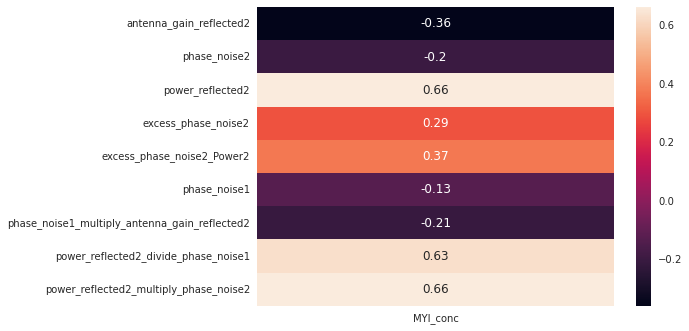

In [421]:
corrdf = pd.DataFrame(eng_df.corrwith(df['MYI_conc']), columns=['MYI_conc'])
sns.heatmap(corrdf, annot=True)

In [426]:
# write out df
df.to_csv('preprocessed_20200301.csv', sep=',', header=True, index=False)

In [43]:
# read preprocessed csv

# using dask
dfd = dd.read_csv('/volstore/spacebridge/gnssr_grzice/preprocessed_gnssr.csv', blocksize=3e6)

dfd.head()

date           time  reflectivity1  reflectivity2  snr_reflected1  \
0  20200301  234613.023234       0.000198       0.000256        0.610670   
1  20200301  234614.023248       0.000188       0.000453        0.654158   
2  20200301  234615.023263       0.000202       0.000146        0.715834   
3  20200301  234616.023278       0.000255       0.000129        0.915882   
4  20200301  234617.023293       0.000134       0.000098        0.478622   

   snr_reflected2  snr_direct1  snr_direct2  phase_noise1  phase_noise2  \
0        0.284695   342.641323   220.302537      2.159402      2.162715   
1        0.543057   342.497420   222.819798      1.773194      2.286698   
2        0.174172   348.710995   221.821909      2.037486      1.859840   
3        0.156795   353.029713   225.311463      2.008366      1.830735   
4        0.120048   351.824993   228.324451      1.953969      2.336481   

   excess_phase_noise1  excess_phase_noise2  power_reflected1  \
0             0.885214             0.317736          10429.44   
1             0.542123             0.935060          10711.04   
2             0.860457            -0.327146          11110.40   
3             0.966550            -0.416574          12405.76   
4             0.513383            -0.045274           9574.40   

   power_reflected2  power_direct1  power_direct2  antenna_gain_reflected1  \
0      23091.209659   2.225153e+06   3.977710e+06                 5.828197   
1      27735.023612   2.224221e+06   4.022955e+06                 5.834707   
2      21104.664620   2.264456e+06   4.005019e+06                 5.834707   
3      20792.322781   2.292420e+06   4.067740e+06                 5.834707   
4      20131.832246   2.284619e+06   4.121896e+06                 5.834707   

   antenna_gain_reflected2  antenna_gain_direct1  antenna_gain_direct2  \
0                 4.570164              0.632180              0.886345   
1                 4.544183              0.560712              0.826557   
2                 4.544183              0.560712              0.826557   
3                 4.544183              0.560712              0.826557   
4                 4.544183              0.560712              0.826557   

        rx_posx       rx_posy       rx_posz       tx_posx       tx_posy  \
0  3.128265e+06 -1.082056e+06 -6.039263e+06 -1.711708e+07 -4.712026e+06   
1  3.133583e+06 -1.086314e+06 -6.035750e+06 -1.711517e+07 -4.713644e+06   
2  3.138897e+06 -1.090572e+06 -6.032229e+06 -1.711326e+07 -4.715262e+06   
3  3.144207e+06 -1.094829e+06 -6.028702e+06 -1.711135e+07 -4.716881e+06   
4  3.149512e+06 -1.099085e+06 -6.025166e+06 -1.710944e+07 -4.718500e+06   

        tx_posz     spec_posx     spec_posy     spec_posz  angle_of_elevation  \
0 -1.994533e+07  1.885831e+06 -1.120392e+06 -5.968992e+06           19.987058   
1 -1.994658e+07  1.889804e+06 -1.124268e+06 -5.967020e+06           19.953787   
2 -1.994782e+07  1.893774e+06 -1.128144e+06 -5.965043e+06           19.920532   
3 -1.994907e+07  1.897739e+06 -1.132020e+06 -5.963061e+06           19.887292   
4 -1.995031e+07  1.901701e+06 -1.135897e+06 -5.961075e+06           19.854068   

   longitude   latitude  YI_conc  FYI_conc  MYI_conc  
0 -30.715003 -69.946577      0.0       0.0       0.0  
1 -30.748947 -69.895078      0.0       0.0       0.0  
2 -30.782784 -69.843585      0.0       0.0       0.0  
3 -30.816514 -69.792099      0.0       0.0       0.0  
4 -30.850139 -69.740620      0.0       0.0       0.0

In [57]:
dfd.dtypes

date                         int64
time                       float64
reflectivity1              float64
reflectivity2              float64
snr_reflected1             float64
snr_reflected2             float64
snr_direct1                float64
snr_direct2                float64
phase_noise1               float64
phase_noise2               float64
excess_phase_noise1        float64
excess_phase_noise2        float64
power_reflected1           float64
power_reflected2           float64
power_direct1              float64
power_direct2              float64
antenna_gain_reflected1    float64
antenna_gain_reflected2    float64
antenna_gain_direct1       float64
antenna_gain_direct2       float64
rx_posx                    float64
rx_posy                    float64
rx_posz                    float64
tx_posx                    float64
tx_posy                    float64
tx_posz                    float64
spec_posx                  float64
spec_posy                  float64
spec_posz           

In [37]:
YI_conc = dfd.pop('YI_conc')
FYI_conc = dfd.pop('FYI_conc')
MYI_conc = dfd.pop('MYI_conc')

dfd

Dask DataFrame Structure:
                date     time reflectivity1 reflectivity2 snr_reflected1 snr_reflected2 snr_direct1 snr_direct2 phase_noise1 phase_noise2 excess_phase_noise1 excess_phase_noise2 power_reflected1 power_reflected2 power_direct1 power_direct2 antenna_gain_reflected1 antenna_gain_reflected2 antenna_gain_direct1 antenna_gain_direct2  rx_posx  rx_posy  rx_posz  tx_posx  tx_posy  tx_posz spec_posx spec_posy spec_posz angle_of_elevation longitude latitude
npartitions=2                                                                                                                                                                                                                                                                                                                                                                                                                                                      
               int64  float64       float64       float64        float64        float64     float64     float64      float64      float64             float64             float64          float64          float64       float64       float64                 float64                 float64              float64              float64  float64  float64  float64  float64  float64  float64   float64   float64   float64            float64   float64  float64
                 ...      ...           ...           ...            ...            ...         ...         ...          ...          ...                 ...                 ...              ...              ...           ...           ...                     ...                     ...                  ...                  ...      ...      ...      ...      ...      ...      ...       ...       ...       ...                ...       ...      ...
                 ...      ...           ...           ...            ...            ...         ...         ...          ...          ...                 ...                 ...              ...              ...           ...           ...                     ...                     ...                  ...                  ...      ...      ...      ...      ...      ...      ...       ...       ...       ...                ...       ...      ...
Dask Name: drop_by_shallow_copy, 8 tasks

In [38]:
# there are ~6550 rows of data in each partition
dfd.map_partitions(len).compute()

0    6552
1    6545
dtype: int64

In [40]:
# simple model to test dask functionality
norm_model = tf.keras.Sequential([
  tf.keras.layers.Normalization(),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(1)
])

norm_model.compile(loss = tf.losses.MeanSquaredError(),
                           optimizer = tf.optimizers.Adam())

norm_model.fit(dfd, MYI_conc, batch_size=1024, epochs=10,)
# does not seem to work :(
# will have to use tf.datasets which is better anyway

ValueError: Failed to find data adapter that can handle input: <class 'dask.dataframe.core.DataFrame'>, <class 'dask.dataframe.core.Series'>

In [70]:
gnssr_csv_path = '/volstore/spacebridge/gnssr_grzice/preprocessed_gnssr.csv'
tfd_gnssr = tf.data.experimental.make_csv_dataset(gnssr_csv_path,
                                                  batch_size=512,
                                                  num_epochs=1,
                                                  shuffle=True,
                                                  shuffle_buffer_size=10000,
                                                  shuffle_seed=202205,
                                                  sloppy=False,
                                                  label_name='YI_conc',
                                                  select_columns=list(range(32))+[32],
                                                  ignore_errors=False,)

tfd_gnssr = tfd_gnssr.cache()

n = sum(1 for _ in tfd_gnssr)
n_train = int(n * 0.8)
n_valid = int(n * 0.1)
n_test = n - n_train - n_valid

train_ds = tfd_gnssr.take(n_train).repeat()
valid_ds = tfd_gnssr.skip(n_train).take(n_valid).repeat()
test_ds = tfd_gnssr.skip(n_train + n_valid).take(n_test)

In [66]:
%%time
sum(1 for _ in tfd_gnssr)
# takes about 10min per epoch to go read the entire 9M row dataset

CPU times: user 9min 37s, sys: 41.2 s, total: 10min 18s
Wall time: 9min 9s


17762

In [69]:
%%time
# with caching
cached = tfd_gnssr.cache()
sum(1 for _ in cached)
# takes about 9min per epoch to go read the entire 9M row dataset with caching

CPU times: user 8min 25s, sys: 43.1 s, total: 9min 8s
Wall time: 7min 17s


17762

In [61]:
for batch, label in tfd_gnssr.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value[:5]}")
  print()
  print(f"{'label':20s}: {label[:5]}")


date                : [20200302 20200302 20200302 20200301 20200302]
time                : [ 91619.05  181246.03   91453.05  132641.05   15518.027]
reflectivity1       : [0.00063299 0.02433069 0.00031487 0.00092028 0.00095824]
reflectivity2       : [0.00109396 0.01967489 0.00135475 0.00039244 0.00108711]
snr_reflected1      : [ 0.31494528 28.824423    0.38452747  2.3320382   1.4084927 ]
snr_reflected2      : [0.23551637 8.590992   0.49247232 0.49651155 0.7790783 ]
snr_direct1         : [ 298.93277  761.25336  572.23505 1362.7991   592.14655]
snr_direct2         : [140.26805 281.196   229.0052  758.5775  300.02078]
phase_noise1        : [1.8948346 0.7395113 1.9370465 1.4675844 1.765326 ]
phase_noise2        : [2.4985359 1.092923  2.5376675 2.2465909 2.0698075]
excess_phase_noise1 : [0.12947173 0.55325127 0.33028793 0.8127954  0.92342615]
excess_phase_noise2 : [0.5106523  0.75174713 1.1176685  0.83243424 0.9412069 ]
power_reflected1    : [  8514.56 191764.48   8965.12  21575.68  15595.52

## Exploratory plotting of GNSS-R data

In [11]:
datetimestr = f"{gnss1.year}{gnss1.month}{gnss1.day} {gnss1.hour}:{gnss1.minute}:{gnss1.second}"
pd.timedelta_range(start=datetimestr, periods=len(gnss1.time), freq='1s')

TimedeltaIndex(['84179 days 14:07:37.023933410',
                '84179 days 14:07:38.023933410',
                '84179 days 14:07:39.023933410',
                '84179 days 14:07:40.023933410',
                '84179 days 14:07:41.023933410',
                '84179 days 14:07:42.023933410',
                '84179 days 14:07:43.023933410',
                '84179 days 14:07:44.023933410',
                '84179 days 14:07:45.023933410',
                '84179 days 14:07:46.023933410',
                ...
                '84179 days 14:13:16.023933410',
                '84179 days 14:13:17.023933410',
                '84179 days 14:13:18.023933410',
                '84179 days 14:13:19.023933410',
                '84179 days 14:13:20.023933410',
                '84179 days 14:13:21.023933410',
                '84179 days 14:13:22.023933410',
                '84179 days 14:13:23.023933410',
                '84179 days 14:13:24.023933410',
                '84179 days 14:13:25.023933410'],

In [30]:
lonice = gnss1.longitude[(gnss1.sea_ice_presence == 1) & (gnss1.flag_master == 0)]
lonwater = gnss1.longitude[(gnss1.sea_ice_presence == 0) & (gnss1.flag_master == 0)]
latice = gnss1.latitude[(gnss1.sea_ice_presence == 1) & (gnss1.flag_master == 0)]
latwater = gnss1.latitude[(gnss1.sea_ice_presence == 0) & (gnss1.flag_master == 0)]
summary(lonice), summary(lonwater), summary(latice), summary(latwater)

((-21.154757436905754, -22.908928955021338, -22.031843195963546),
 (-21.016599235847877, -35.337494628984075, -28.177046932415976),
 (-72.37695685383878, -73.48221277476915, -72.92958481430396),
 (-61.21857892306003, -73.56444599895367, -67.39151246100685))

/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/stefan/mambaf

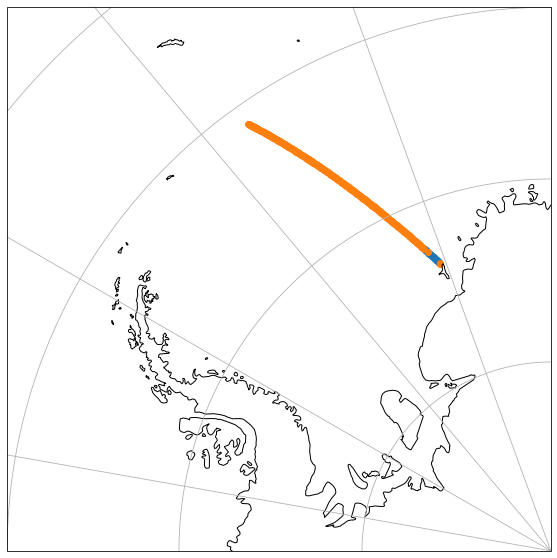

In [31]:
# from mpl_toolkits.basemap import Basemap
# use low resolution coastlines.
# map = Basemap(projection='ortho',lat_0=-90,lon_0=0,resolution='l')
fig, ax = plt.subplots(
    1, 1, subplot_kw=dict(projection=ccrs.Orthographic(0,-90))
)
# extent = ax.get_extent(crs=ccrs.PlateCarree())
# print(extent)
ax.scatter(lonice, latice, transform=ccrs.PlateCarree())
ax.scatter(lonwater, latwater, transform=ccrs.PlateCarree())
ax.set_extent((-90,0,-90,-60))
ax.coastlines()
ax.gridlines()

## GNSS Metadata

In [4]:
DIR = '/volstore/spacebridge/spacebridge_csv'
files = [os.path.join(DIR,pth) for pth in os.listdir(DIR)]
files.sort()
files

['/volstore/spacebridge/spacebridge_csv/MLTraining_202002.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202003.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202004.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202005.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202006.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202007.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202008.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202009.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202010.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202011.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202012.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202101.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202102.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202103.csv',
 '/volstore/spacebridge/spacebridge_csv/MLTraining_202104.csv',
 '/volstore/spacebridge/spacebridge_csv/

In [5]:
class GNSS_meta(object):
    def __init__(self, path):
        self.path = path
        self.year = os.path.basename(os.path.splitext(self.path)[0])[-6:-2]
        self.mon = os.path.basename(os.path.splitext(self.path)[0])[-2:]
        self.load()
    def load(self):
        self.data = pd.read_csv(self.path, usecols = [1,2,3])
        try:
            iceconc_mean = xr.open_dataset(f'/volstore/spacebridge/iceconc_osisaf/{self.year}/{self.mon}/ice_conc_sh_polstere-100_multi_{self.year}{self.mon}_monmean.nc')
            iceedge = pd.DataFrame({'lon': iceconc_mean.ice_conc.lon.data.flatten(),
                            'lat': iceconc_mean.ice_conc.lat.data.flatten(),
                            'edge': iceconc_mean.ice_conc.data.flatten()})
            iceedge = iceedge[(iceedge['edge'] > 14.5) & (iceedge['edge'] < 15.5)] 
            iceedge.sort_values(by='lon',inplace=True)
            self.iceedge = iceedge
        except FileNotFoundError as fnf_error:
            self.iceedge = None
            print(fnf_error)
    def __str__(self):
        return str(self.data.head())
    def __repr__(self):
        return str(self)
    def __len__(self):
        return len(self.data)
    def set_extent(self, lat1, lat2, lon1=-180, lon2=180):
        assert lon1 < lon2, 'lon1 must be smaller than lon2'
        assert lat1 < lat2, 'lat1 must be smaller than lat2'
        self.data = self.data[(self.data['latitude'] > lat1) & (self.data['latitude'] <= lat2) & (self.data['longtiude'] > lon1) & (self.data['longtiude'] <= lon2)]
    def plot(self, fig=None, ax=None, legend=True):
        if fig is None:
            fig = plt.figure()
            ax = plt.axes(projection=ccrs.Orthographic(0,-90))
            ax.set_extent([-180,180,-50,-90],crs=ccrs.PlateCarree())
        else:
            assert ax is not None, 'Axes must be provided for multi-panel plot'
        im = ax.hexbin(x=self.data['longtiude'], y=self.data['latitude'], gridsize=(3*36,3*18), cmap='Greens', transform=ccrs.PlateCarree())
        fig.colorbar(im, label='hexbins of number of\nGNSS scatterometer pings', ax=ax)
        ax.set_title(f'{self.year} {self.mon}')
        ax.coastlines()
        if self.iceedge is not None:
            ax.plot(self.iceedge.lon,self.iceedge.lat,label='Antarctic ice edge', transform=ccrs.PlateCarree())
            if legend:
                ax.legend()

/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/stefan/mambaf

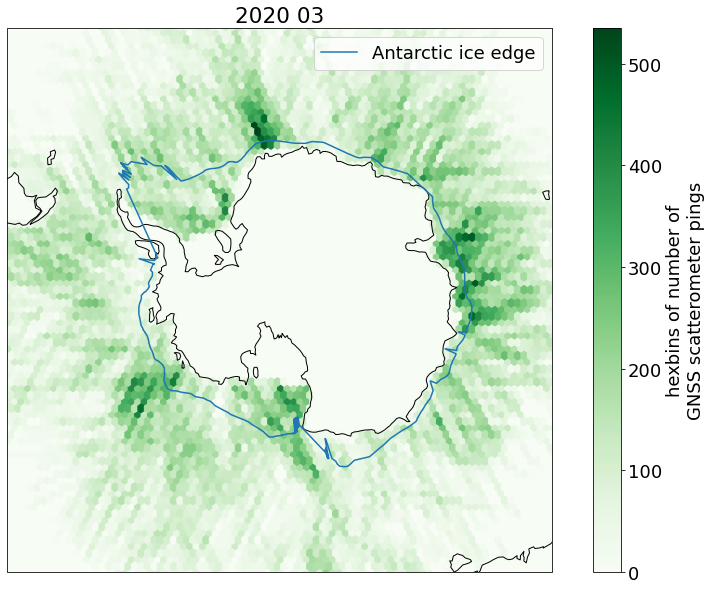

In [6]:
f = GNSS_meta(files[1])
f.plot()

In [7]:
f = GNSS_meta(files[0])
f.data

latitude  longtiude          time
0       65.392926 -39.022798  1.265607e+09
1       65.343509 -39.050232  1.265607e+09
2       65.294101 -39.077616  1.265607e+09
3       65.244701 -39.104950  1.265607e+09
4       65.195310 -39.132235  1.265607e+09
...           ...        ...           ...
210009  65.085143 -54.696937  1.267056e+09
210010  65.126901 -54.737484  1.267056e+09
210011  65.168680 -54.778173  1.267056e+09
210012  65.210480 -54.819006  1.267056e+09
210013  65.252301 -54.859983  1.267056e+09

[210014 rows x 3 columns]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/stefan/mambaf

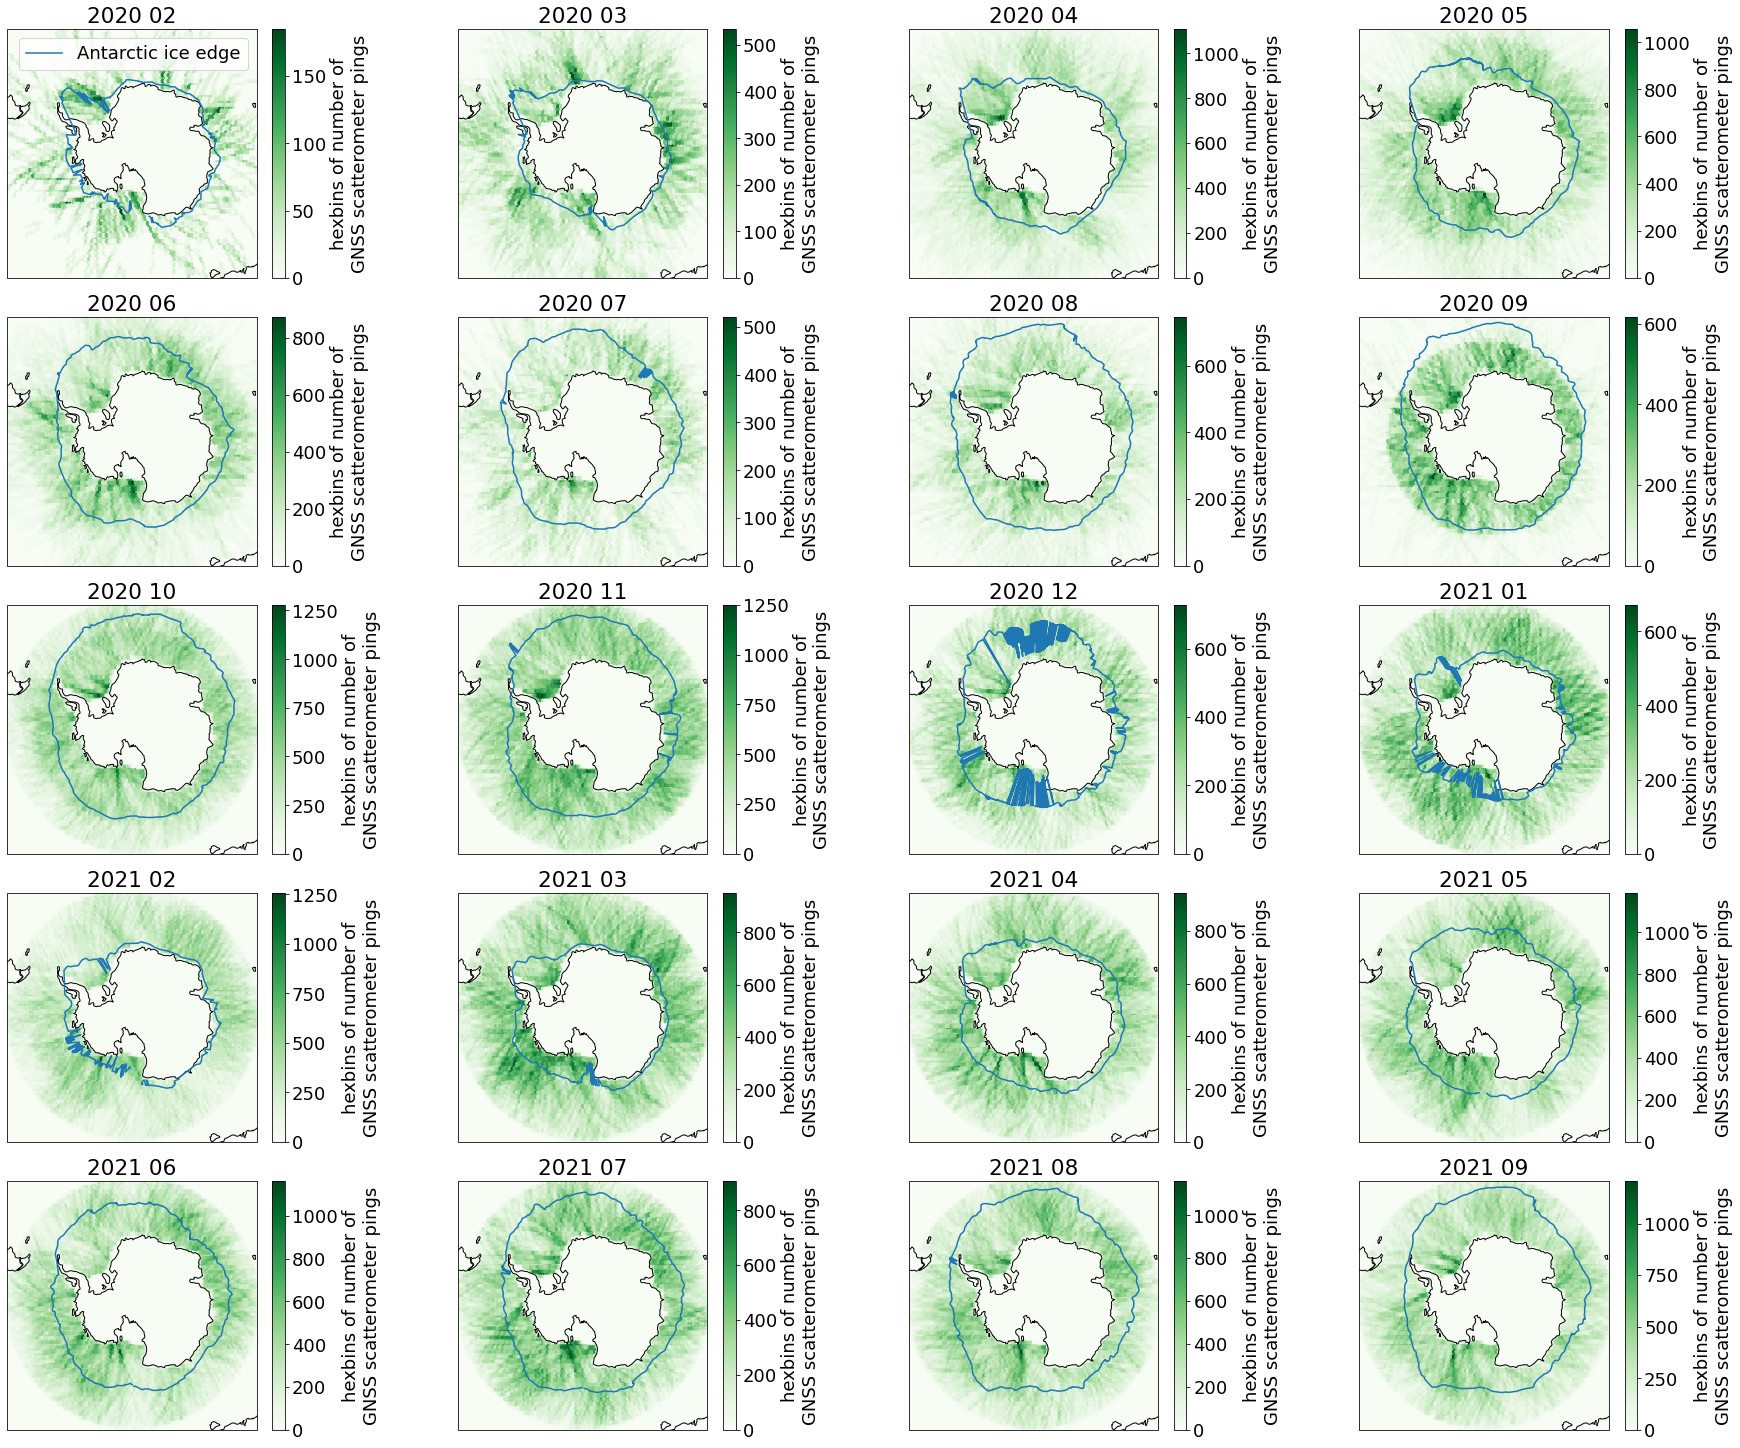

In [60]:
PATHS = files
fig, axs = plt.subplots(ncols=4, nrows=5, constrained_layout=True, subplot_kw={'projection':ccrs.Orthographic(0,-90)})
for k, ax in enumerate(axs.flatten()):
    print(k)
    ax.set_extent([-180,180,-50,-90], crs=ccrs.PlateCarree())
    GNSS = GNSS_meta(PATHS[k])
    legend = True if k == 0 else False
    GNSS.plot(fig=fig, ax=ax, legend=legend)

In [86]:
GNSS_202103.set_extent(-90, 0)
len(GNSS_202103)

116017

## University of Bremen MultiYear Ice Concentration

- Using the raw/uncorrected netcdfs because they contain other ice types.
- The original "final" netcdfs on volstore only contain the MYI variables and do not even contain the lon/lat variables.

In [206]:
ds1 = xr.open_dataset('/volstore/spacebridge/iceage_Melsheimer/Icetypes/ECICE-IcetypesUncorrected-20200301.nc')
ds2 = xr.open_dataset('/volstore/spacebridge/iceage_Melsheimer/Icetypes/ECICE-IcetypesUncorrected-20200302.nc')
lon = ds.LON.values
lat = ds.LAT.values

In [212]:
ds2.LON

<xarray.DataArray 'LON' (X: 664, Y: 632)>
array([[ -42.236737,  -42.146228,  -42.05546 , ...,   42.05546 ,   42.146228,
          42.236737],
       [ -42.318924,  -42.228389,  -42.137595, ...,   42.137595,   42.228389,
          42.318924],
       [ -42.40137 ,  -42.310811,  -42.219991, ...,   42.219991,   42.310811,
          42.40137 ],
       ...,
       [-134.81782 , -134.908765, -135.      , ...,  135.      ,  134.908765,
         134.81782 ],
       [-134.909054, -135.      , -135.091235, ...,  135.091235,  135.      ,
         134.909054],
       [-135.      , -135.090946, -135.18218 , ...,  135.18218 ,  135.090946,
         135.      ]])
Dimensions without coordinates: X, Y
Attributes:
    units:    degrees_east

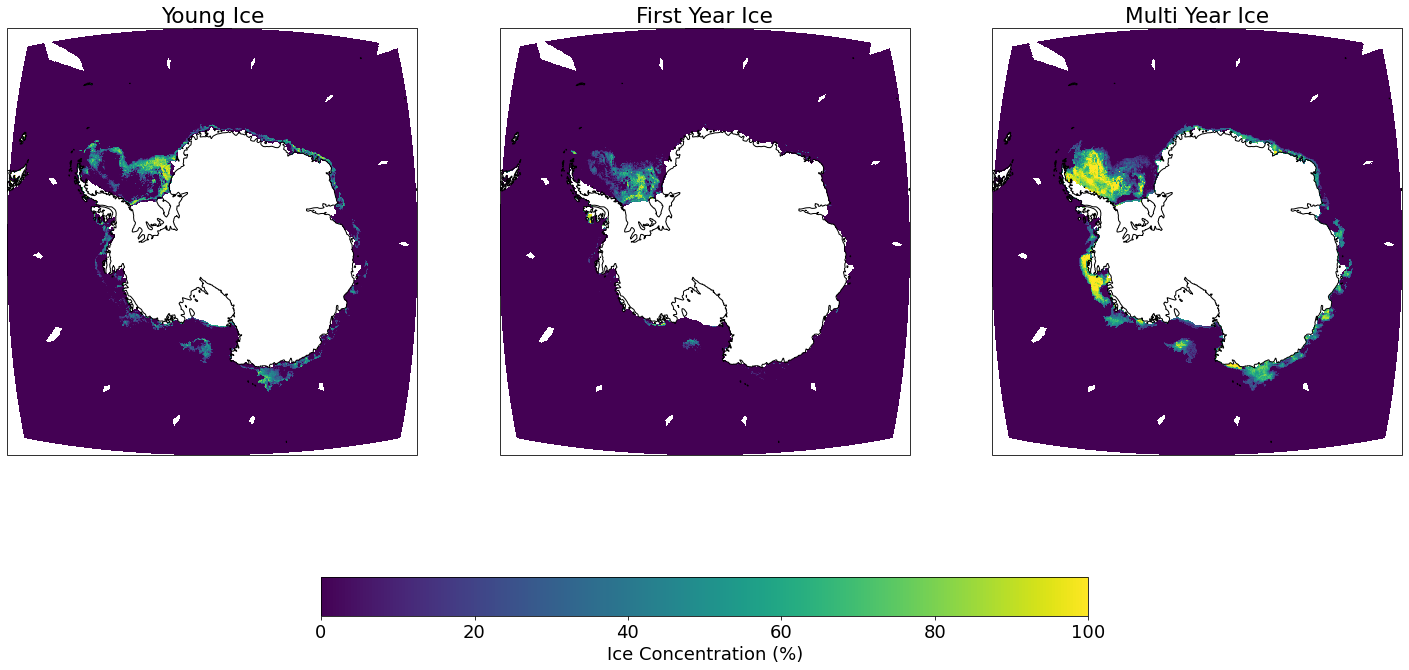

In [289]:
fig, axs = plt.subplots(1,3,figsize=[25,15], subplot_kw={'projection':ccrs.Orthographic(0,-90)})
im = axs[0].pcolormesh(lon, lat, ds.YI, transform=ccrs.PlateCarree())
axs[0].coastlines(resolution="50m")
axs[0].set_title("Young Ice")
im = axs[1].pcolormesh(lon, lat, ds.FYI, transform=ccrs.PlateCarree())
axs[1].coastlines(resolution="50m")
axs[1].set_title("First Year Ice")
im = axs[2].pcolormesh(lon, lat, ds.MYI, transform=ccrs.PlateCarree())
axs[2].coastlines(resolution="50m")
axs[2].set_title("Multi Year Ice")
plt.colorbar(im,ax=axs,label="Ice Concentration (%)", shrink=0.55,location='bottom', orientation='horizontal')

## OSI-SAF Ice Concentration

In [293]:
ic = xr.open_dataset('/volstore/spacebridge/iceconc_osisaf/2020/03/ice_conc_sh_polstere-100_multi_202003011200.nc')
ic

<xarray.Dataset>
Dimensions:                   (time: 1, nv: 2, xc: 790, yc: 830)
Coordinates:
  * time                      (time) datetime64[ns] 2020-03-01T12:00:00
  * xc                        (xc) float64 -3.945e+03 -3.935e+03 ... 3.945e+03
  * yc                        (yc) float64 4.345e+03 4.335e+03 ... -3.945e+03
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Polar_Stereographic_Grid  int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    ice_conc                  (time, yc, xc) float32 ...
    ice_conc_unfiltered       (time, yc, xc) float32 ...
    masks                     (time, yc, xc) float32 ...
    confidence_level          (time, yc, xc) float32 ...
    status_flag               (time, yc, xc) float32 ...
    total_uncertainty         (time, yc, xc) float32 ...
    smearing_uncertainty      (time, yc, xc) float32 ...
    algorithm_uncertainty     (time, yc, xc) float32 ...
Attributes: (12/30)
    title:                   Daily Sea Ice Concentration Analysis from OSI SA...
    product_id:              OSI-401
    product_name:            osi_saf_ice_conc
    product_status:          operational
    abstract:                The daily analysis of sea ice concentration is o...
    topiccategory:           Oceans Climatology Meteorology Atmosphere
    ...                      ...
    references:              Product User Manual for OSI SAF Global Sea Ice C...
    history:                 2020-03-02 creation
    product_version:         4.0
    software_version:        1.3
    netcdf_version:          3.6.3
    Conventions:             CF-1.6

/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/stefan/mambaf

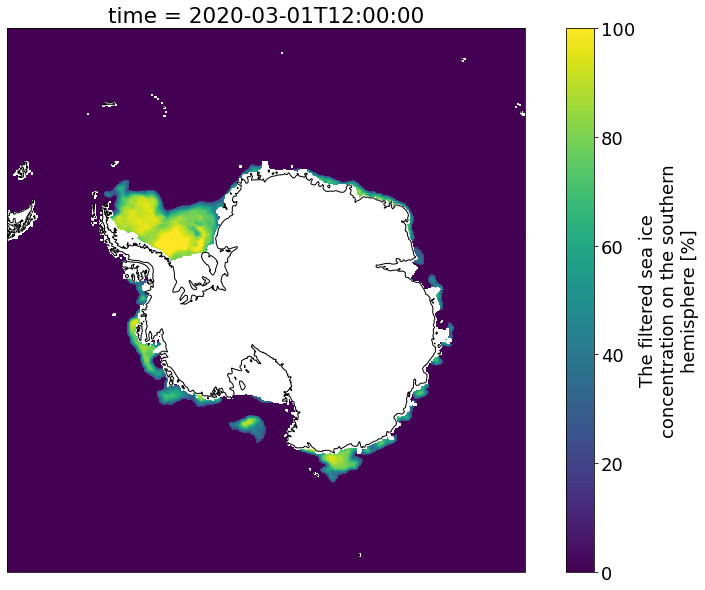

In [295]:
fig = ic.ice_conc.plot(x="lon", y="lat", transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.SouthPolarStereo()))
fig.axes.coastlines(resolution="50m")

## Fraser et al. 2021 Fast Ice Persistenceresolution=

In [ ]:
ds = xr.open_dataset('/volstore/spacebridge/fraser_2021_fastice_persistence/fastice_v2.2_persistence.nc')
ds

<xarray.Dataset>
Dimensions:       (Y: 4700, X: 5625)
Coordinates:
    latitude      (Y, X) float32 ...
    longitude     (Y, X) float32 ...
Dimensions without coordinates: Y, X
Data variables:
    persistence   (Y, X) float32 ...
    groundedmask  (Y, X) float32 ...
    iceshelfmask  (Y, X) float32 ...

In [15]:
ds.lat.dims[1]

'X'

/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/stefan/mambaforge/envs/spacebridge/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/stefan/mambaf

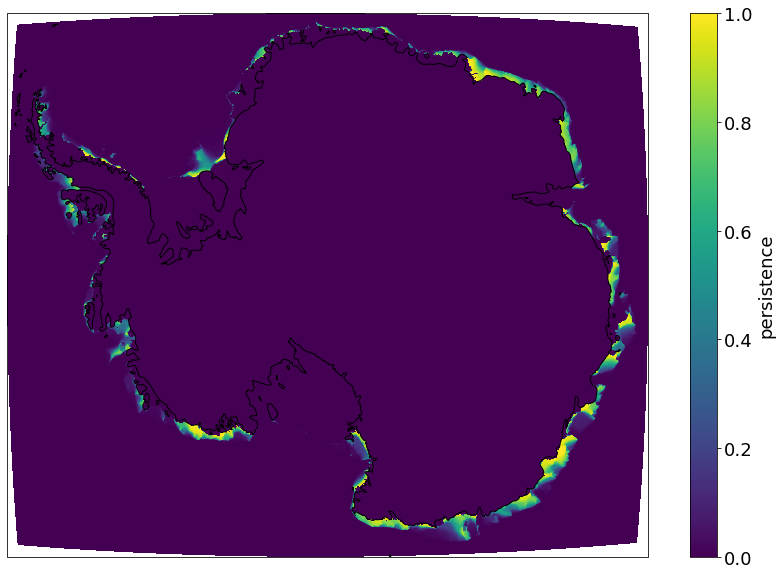

In [70]:
fig = ds.persistence.plot(x="longitude", y="latitude", transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.Orthographic(0,-90)})
fig.axes.coastlines()

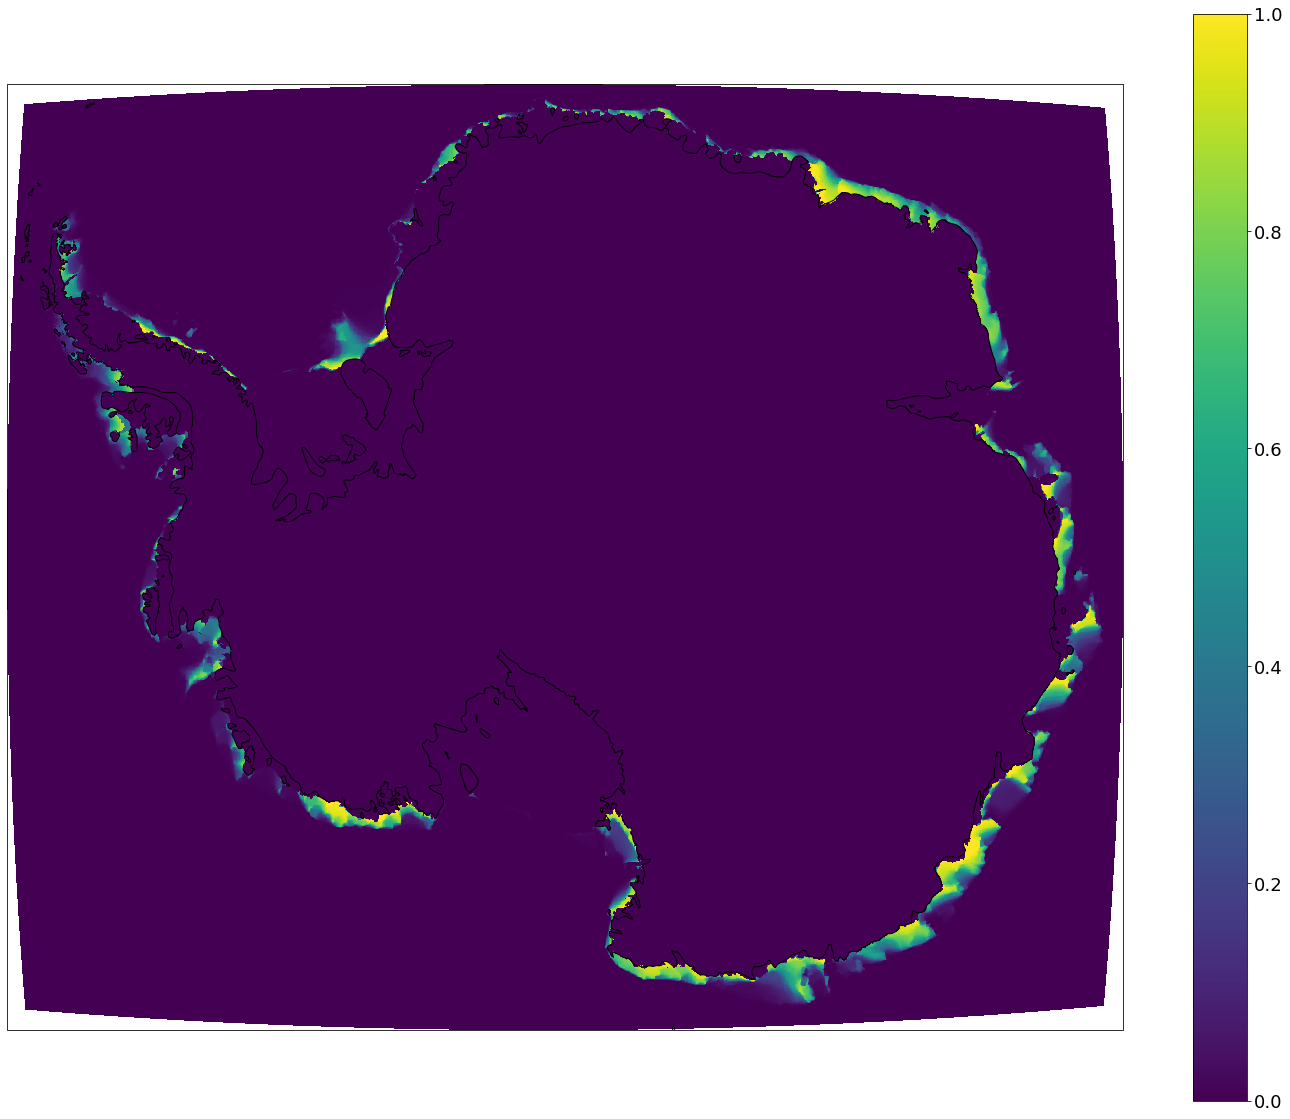

In [27]:
fig, ax = plt.subplots(
    1, 1, subplot_kw=dict(projection=ccrs.Orthographic(0,-90))
)

f = ax.pcolormesh(ds.longitude.values[0::4, 0::4], ds.latitude.values[0::4, 0::4], ds.persistence.values[0::4, 0::4], transform=ccrs.PlateCarree())
ax.coastlines()
fig.colorbar(f, ax=ax)

## ICESAT-2

In [82]:
is2 = xr.open_dataset('/volstore/spacebridge/icesat-2/ATL07/version5/2020-10-01_to_2020-12-31/ATL07-02_20201030214037_05610901_005_01.h5')
is2

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/47)
    Conventions:                        CF-1.6
    contributor_name:                   Thomas E Neumann (thomas.neumann@nasa...
    contributor_role:                   Instrument Engineer, Investigator, Pr...
    date_type:                          UTC
    description:                        The data set (ATL07) contains along-t...
    featureType:                        trajectory
    ...                                 ...
    processing_level:                   2A
    references:                         http://nsidc.org/data/icesat2/data.html
    project:                            ICESat-2 > Ice, Cloud, and land Eleva...
    instrument:                         ATLAS > Advanced Topographic Laser Al...
    platform:                           ICESat-2 > Ice, Cloud, and land Eleva...
    source:                             Spacecraft

## NASA BYU

**Metadata based on file names:**

filename example: msfa-p-Ant20-364-365.sir.gz 

file naming convention: SENS-T-REGYR-DY1-DY2.RCN (without extension)

SENS (sensor): msfa -> MetOp-A and MetOp-B Advanced Scatterometer (ASCAT) 

T (image type): p -> available types: a  b  C  E  I  J  p  V

    - a (1) = A image (sigma-0 in dB, typically at 40 deg incidence)
    - b (2) = B image (slope of sigma-0 in dB/deg)
    - C (8) = counts or hits (measurements) per pixel
    - E (21) = Sigma-0 error image (dB)
    - I (7) = incidence angle standard deviation (in deg)
    - J (9) = average incidence angle (in deg)
    - p (11) = pixel time estimate (in min from start of image interval)
    - V (22) = Sigma-0 standard deviation image (dB)

REG (Region): Ant -> Antarctica

YR (Year): 20 -> 2020

DY1 (start day): 364

DY2 (end day): 364 (daily)

RCN (reconstruction technique): sir -> sir or sirf algorithm


In [7]:
# import sys
# sys.path.append("/home/stefan/GIT_REPOS/spacebridge/pkgs")

# import SIRpy

# SIRpy.sir_io.loadsir('/volstore/spacebridge/nasa_scp_byu/2020/003/a/msfa-a-Ant20-003-004.sir')

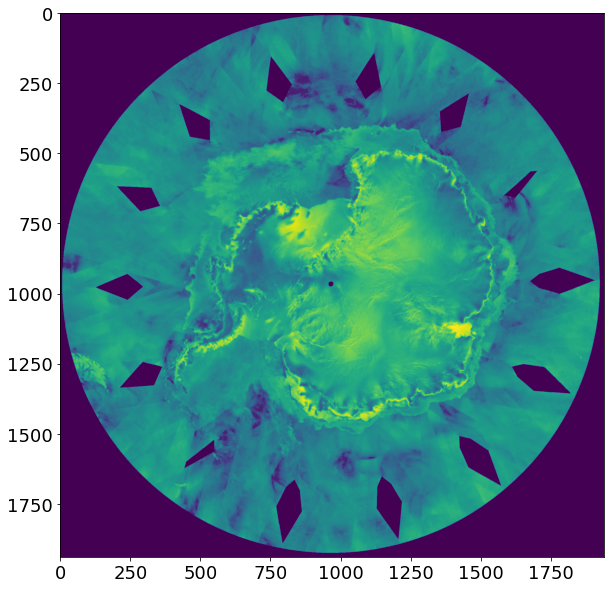

In [137]:
rotfilename='/volstore/spacebridge/nasa_scp_byu/2020/a_imgfiles/msfa-a-Ant20-002-003.sir.img'
with open(rotfilename, 'rb') as f:
    temprot=np.fromfile(f, dtype=np.float32)
    rot=np.reshape(temprot, [1940,1940])
plt.imshow(rot)

In [104]:
1940**2

3763600

## Ice concentration edge

In [8]:
iceconc_max = xr.open_dataset('/volstore/spacebridge/iceconc_osisaf/2021/09/ice_conc_sh_polstere-100_multi_202109_monmax.nc')
iceconc_mean = xr.open_dataset('/volstore/spacebridge/iceconc_osisaf/2021/09/ice_conc_sh_polstere-100_multi_202109_monmean.nc')
iceconc_max

<xarray.Dataset>
Dimensions:                   (time: 1, bnds: 2, yc: 830, xc: 790)
Coordinates:
  * time                      (time) datetime64[ns] 2021-09-16
    lon                       (yc, xc) float32 ...
    lat                       (yc, xc) float32 ...
  * xc                        (xc) float64 -3.945e+03 -3.935e+03 ... 3.945e+03
  * yc                        (yc) float64 4.345e+03 4.335e+03 ... -3.945e+03
Dimensions without coordinates: bnds
Data variables:
    time_bnds                 (time, bnds) datetime64[ns] ...
    Polar_Stereographic_Grid  int32 ...
    ice_conc                  (time, yc, xc) float32 ...
    ice_conc_unfiltered       (time, yc, xc) float32 ...
    masks                     (time, yc, xc) float32 ...
    confidence_level          (time, yc, xc) float32 ...
    status_flag               (time, yc, xc) float32 ...
    total_uncertainty         (time, yc, xc) float32 ...
    smearing_uncertainty      (time, yc, xc) float32 ...
    algorithm_uncertainty     (time, yc, xc) float32 ...
Attributes: (12/33)
    CDI:                     Climate Data Interface version 1.9.9rc1 (https:/...
    Conventions:             CF-1.6
    history:                 Fri Dec 10 00:55:30 2021: cdo monmax ice_conc_sh...
    institution:             EUMETSAT OSI SAF
    title:                   Daily Sea Ice Concentration Analysis from OSI SA...
    product_id:              OSI-401
    ...                      ...
    references:              Product User Manual for OSI SAF Global Sea Ice C...
    product_version:         4.0
    software_version:        1.3
    netcdf_version:          3.6.3
    frequency:               mon
    CDO:                     Climate Data Operators version 1.9.9rc1 (https:/...

In [29]:
len(iceconc_mean.ice_conc.data.flatten())

655700

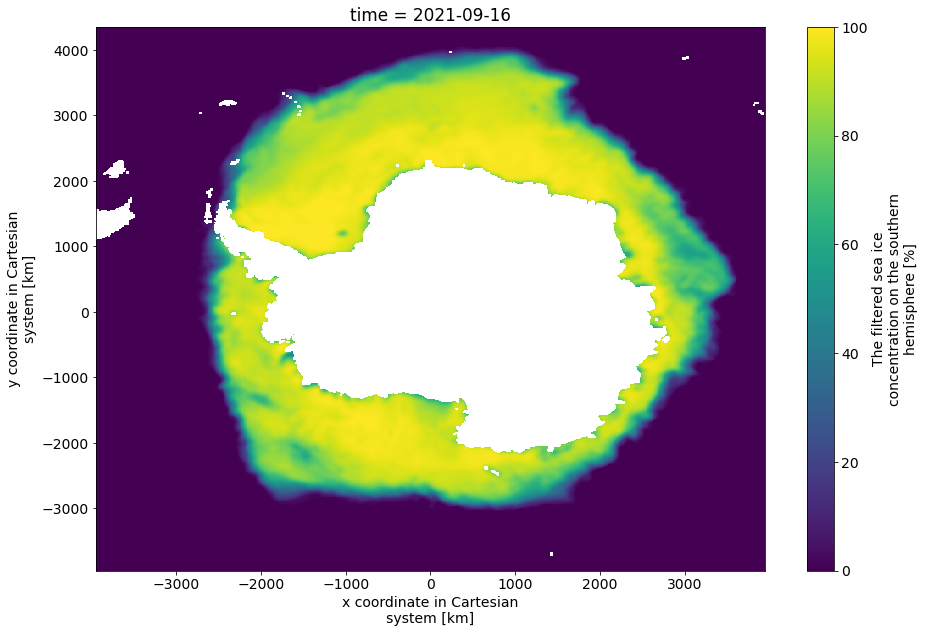

In [16]:
iceconc_mean.ice_conc.where(icecon_mean.ice_conc == plot()

In [10]:
iceedge = pd.DataFrame({'lon': iceconc_mean.ice_conc.lon.data.flatten(),
                        'lat': iceconc_mean.ice_conc.lat.data.flatten(),
                        'edge': iceconc_mean.ice_conc.data.flatten()})
iceedge = iceedge[(iceedge['edge'] > 14.5) & (iceedge['edge'] < 15.5)] 
iceedge.sort_values(by='lon',inplace=True)
zip(iceedge.lon, iceedge.lat)

# Exploratory

## UTAS-NIWA-wave-buoy

In [17]:
plt.rcParams["figure.figsize"] = (20,10)

In [12]:
wb = xr.open_dataarray('/volstore/spacebridge/UTAS-NIWA-wave-buoy/JAPAN_UTAS_waves_ice_2020_fromalison_5jul2021.nc')
wb

MissingDimensionsError: 'time_string' has more than 1-dimension and the same name as one of its dimensions ('time_string', 'chid'). xarray disallows such variables because they conflict with the coordinates used to label dimensions.

In [53]:
from netCDF4 import Dataset
import numpy.ma as ma

In [14]:
wb = Dataset('/volstore/spacebridge/UTAS-NIWA-wave-buoy/JAPAN_UTAS_waves_ice_2020_fromalison_5jul2021.nc', mode='r')
wb.variables.keys()

dict_keys(['buoy', 'time', 'moments_header', 'bin', 'time_string', 'time_str', 'lat', 'lon', 'Tp', 'Hs', 'Hs_processed', 'moments_raw', 'moments_processed', 'psd', 'psd_processed', 'temp', 'deployed', 'qf_mean_removed', 'qf_imu_accel', 'qf_imu_gyro', 'qf_imu_mag', 'qf_gps'])

In [15]:
buoy = wb.variables['buoy'][:]
time = wb.variables['time'][:]
lon  = wb.variables['lon'][:]
lat  = wb.variables['lat'][:]
Tp   = wb.variables['Tp'][:]
Hs   = wb.variables['Hs'][:]
Hs_processed = wb.variables['Hs_processed'][:]

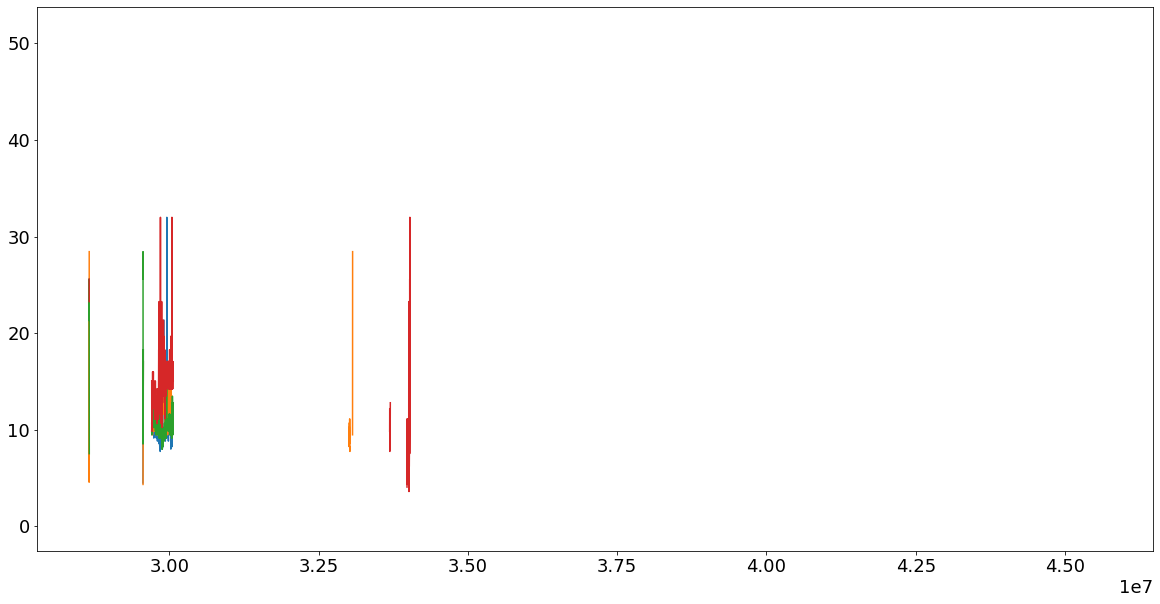

In [18]:
plt.plot(time, Tp[0])
# plt.plot(time, Tp[1])
plt.plot(time, Tp[2])
plt.plot(time, Tp[3])
plt.plot(time, Tp[4])

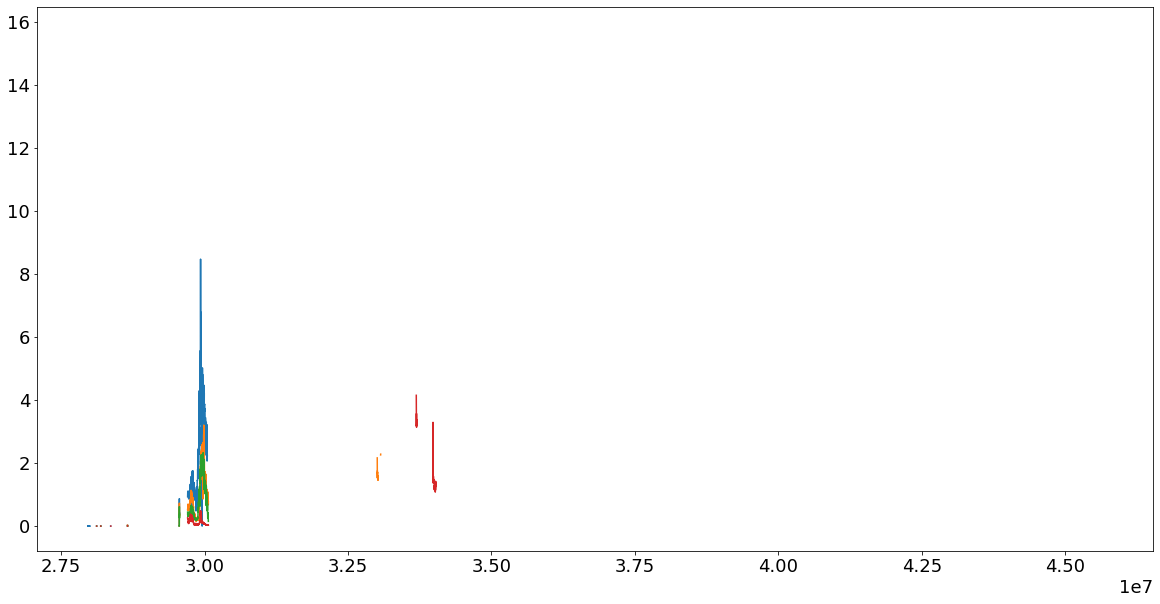

In [19]:
plt.plot(time, Hs_processed[0])
# plt.plot(time, Tp[1])
plt.plot(time, Hs_processed[2])
plt.plot(time, Hs_processed[3])
plt.plot(time, Hs_processed[4])

In [38]:
lon[0].compressed().shape, lat[0].compressed().shape, Tp[0].compressed().shape, Hs[0].compressed().shape, Hs_processed[0].compressed().shape

((531,), (531,), (474,), (474,), (533,))

In [78]:
[(np.min(lon.compressed())), np.max(lon.compressed()) + 100]

[0.0, 14523617.0]

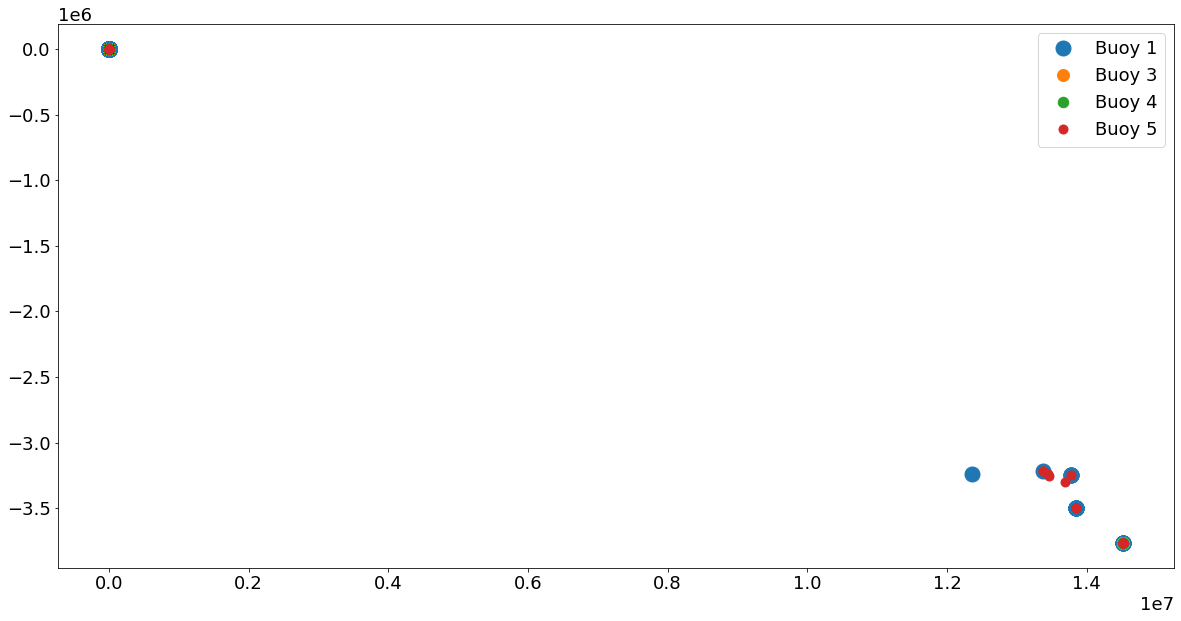

In [80]:
valid_buoys = ma.array(np.arange(5), mask=[0,1]+3*[0])
for i in valid_buoys.compressed():
    plt.plot(lon[i].compressed(), lat[i].compressed(), '.', label=f'Buoy {i+1}', markersize = 30-3*i)
# plt.xlim([np.min(lon.compressed()), np.max(lon.compressed())])
# plt.ylim([np.min(lat.compressed()), np.max(lat.compressed())])
plt.legend()


In [70]:
lat[0].compressed()

array([-3.76516151e+01, -3.76519928e+01, -3.76516304e+01, -3.76511841e+01,
       -3.76514969e+01, -3.76514969e+01, -3.76512451e+01, -3.76512451e+01,
       -3.76516953e+01, -3.76516953e+01, -3.76517715e+01, -3.76516876e+01,
       -3.76515961e+01, -3.76516609e+01, -3.76518364e+01, -3.76518364e+01,
       -3.76517143e+01, -3.76516495e+01, -3.76519318e+01, -3.76518250e+01,
       -3.76517500e+06, -3.76516400e+06, -3.76515300e+06, -3.76518600e+06,
       -3.76514400e+06, -3.76514400e+06, -3.49789200e+06, -3.49789200e+06,
       -3.49793400e+06, -3.49792100e+06, -3.49792100e+06, -3.49792100e+06,
       -3.49792100e+06, -3.49792100e+06, -3.24836900e+06, -3.24836900e+06,
       -3.24836900e+06, -3.24836900e+06, -3.21269200e+06, -3.23515900e+06,
       -3.20536842e+01, -3.20539131e+01, -3.20538673e+01, -3.20555763e+01,
       -3.20535965e+01, -3.20535164e+01, -3.20537033e+01, -3.20537376e+01,
       -3.20536308e+01, -3.20536537e+01, -6.42518082e+01, -6.42518082e+01,
       -6.42869110e+01, -

## Sentinel 1

In [101]:
# im = cv2.imread('/volstore/spacebridge/sentinel1/S1A_EW_GRDM_1SDH_20200913T143952_GEO000.data/Amplitude_HH.img')
# file = open('/volstore/spacebridge/sentinel1/S1A_EW_GRDM_1SDH_20200913T143952_GEO000.data/Amplitude_HH.img', 'rb')
# data = np.fromfile(file, np.dtype('>u2'))
data = data.reshape([27982,26716])

In [103]:
#from #lines and #samples from the .hdr file
27982*26716, data.shape

(747567112, (27982, 26716))

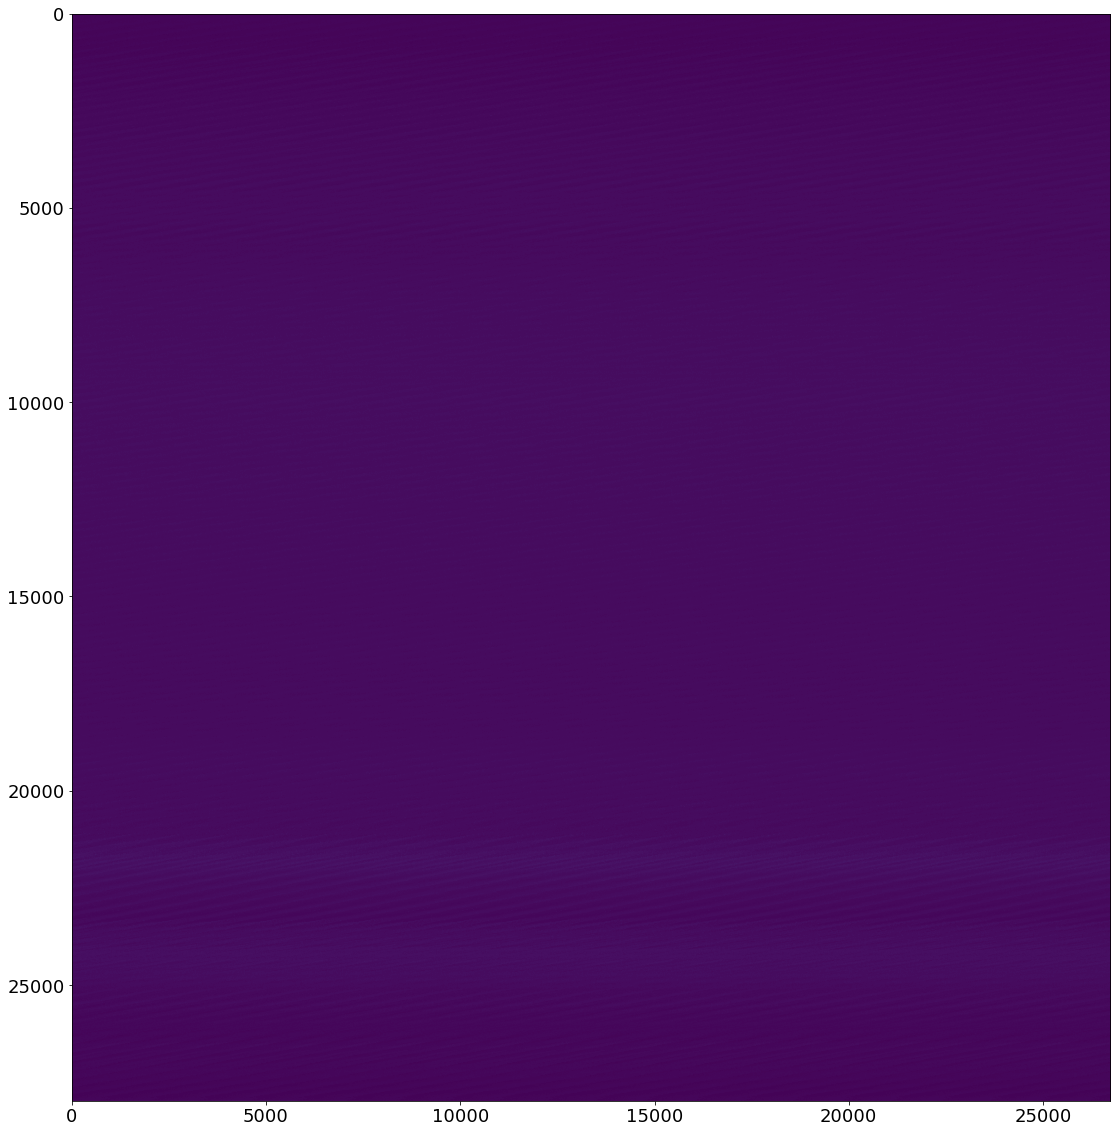

In [104]:
plt.imshow(data)